In [9]:
import mwclient  # Imports the mwclient library for interacting with the MediaWiki API.
import time  # Imports the time library for managing time-related tasks.

site = mwclient.Site('en.wikipedia.org')  # Connects to the English Wikipedia site.
page = site.pages['Ethereum']  # Retrieves the page object for the Wikipedia article titled "Ethereum."

In [10]:
#assign revisions page to 'revs' list
revs = list(page.revisions())

In [11]:
revs[0]

OrderedDict([('revid', 1257117784),
             ('parentid', 1252608296),
             ('user', 'HmmInterdasting'),
             ('timestamp',
              time.struct_time(tm_year=2024, tm_mon=11, tm_mday=13, tm_hour=9, tm_min=36, tm_sec=24, tm_wday=2, tm_yday=318, tm_isdst=-1)),
             ('comment', '/* Accounts */ Message calls are not transactions')])

In [12]:
#sort in reverse order of timestamp
revs = sorted(revs, key=lambda rev: rev['timestamp'])

In [13]:
revs[0]

OrderedDict([('revid', 592567939),
             ('parentid', 0),
             ('user', 'Sanpitch'),
             ('timestamp',
              time.struct_time(tm_year=2014, tm_mon=1, tm_mday=27, tm_hour=1, tm_min=53, tm_sec=45, tm_wday=0, tm_yday=27, tm_isdst=-1)),
             ('comment',
              "[[WP:AES|←]]Created page with '{{Infobox currency | image_1 =  | image_title_1 =  | image_width_1 =  | image_2 =  | image_title_2 =  | image_width_2 =  |issuing_authority = None. The Ethereum...'")])

In [14]:
from transformers import pipeline  # Imports the Hugging Face Transformers library to use pre-trained models.
sentiment_pipeline = pipeline('sentiment-analysis')  # Initializes a sentiment analysis pipeline.

def find_sentiment(text):  # Defines a function to determine the sentiment score of a given text.
    sent = sentiment_pipeline([text[:250]])[0]  # Analyzes the sentiment of the first 250 characters of the text and retrieves the result.
    score = sent['score']  # Extracts the confidence score of the sentiment.
    if sent['label'] == 'NEGATIVE':  # Checks if the sentiment is negative.
        score *= -1  # Converts the score to a negative value for negative sentiments.
    return score

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [15]:
edits = {}  # Initializes an empty dictionary to store edit data grouped by date.

for rev in revs:  # Iterates through each revision in the list of revisions.
    date = time.strftime('%Y-%m-%d', rev['timestamp'])  # Formats the revision timestamp into a 'YYYY-MM-DD' string.

    if date not in edits:  # Checks if the date is not already in the edits dictionary.
        edits[date] = dict(sentiments=list(), edit_count=0)  # Creates a new entry with a list for sentiments and a counter for edits.

    edits[date]['edit_count'] += 1  # Increments the edit count for the specific date.

    comment = rev.get('comment', '')  # Retrieves the 'comment' field from the revision, defaults to an empty string if missing.
    if comment:  # Proceeds only if the comment is not empty.
        edits[date]['sentiments'].append(find_sentiment(comment))  # Appends the sentiment score of the comment to the sentiments list.

In [16]:
from statistics import mean  # Imports the mean function to calculate the average of a list.

for key in edits:  # Iterates through each date (key) in the edits dictionary.
    if len(edits[key]['sentiments']) > 0:  # Checks if there are any sentiment scores for the date.
        edits[key]['sentiment'] = mean(edits[key]['sentiments'])  # Calculates the average sentiment score for the date.
        edits[key]['neg_sentiment'] = len([s for s in edits[key]['sentiments'] if s < 0]) / len(edits[key]['sentiments'])  
        # Calculates the proportion of negative sentiment scores for the date.
    else:  # If no sentiments exist for the date:
        edits[key]['sentiment'] = 0  # Sets the average sentiment to 0.
        edits[key]['neg_sentiment'] = 0  # Sets the proportion of negative sentiments to 0.

    del edits[key]['sentiments']  # Removes the 'sentiments' list from the dictionary to save memory.

In [17]:
import pandas as pd

edits_df = pd.DataFrame.from_dict(edits, orient='index')  
# Converts the `edits` dictionary into a pandas DataFrame, using dictionary keys as row indices.

In [18]:
edits_df

,edit_count,sentiment,neg_sentiment
2014-01-27,1,-0.998511,1.000000
2014-02-01,1,-0.997276,1.000000
2014-04-06,5,0.962413,0.000000
2014-04-09,24,0.476884,0.222222
2014-04-10,9,-0.500223,0.750000
...,...,...,...
2024-09-09,1,0.930021,0.000000
2024-09-29,1,0.994775,0.000000
2024-10-09,1,-0.999581,1.000000
2024-10-22,1,-0.999592,1.000000


In [19]:
# Converts the DataFrame's index (dates) to datetime objects for easier time-based operations and analysis.
edits_df.index = pd.to_datetime(edits_df.index)

In [20]:
from datetime import datetime

dates = pd.date_range(start='2014-01-27', end=datetime.today()) # Generates a range of dates from January 27, 2014, to the current date.

In [21]:
dates

DatetimeIndex(['2014-01-27', '2014-01-28', '2014-01-29', '2014-01-30',
               '2014-01-31', '2014-02-01', '2014-02-02', '2014-02-03',
               '2014-02-04', '2014-02-05',
               ...
               '2024-11-15', '2024-11-16', '2024-11-17', '2024-11-18',
               '2024-11-19', '2024-11-20', '2024-11-21', '2024-11-22',
               '2024-11-23', '2024-11-24'],
              dtype='datetime64[ns]', length=3955, freq='D')

In [22]:
# Reindexes the DataFrame to include all dates in the generated range, filling missing dates with default values (0).
edits_df = edits_df.reindex(dates, fill_value=0)

In [23]:
edits_df

,edit_count,sentiment,neg_sentiment
2014-01-27,1,-0.998511,1.0
2014-01-28,0,0.000000,0.0
2014-01-29,0,0.000000,0.0
2014-01-30,0,0.000000,0.0
2014-01-31,0,0.000000,0.0
...,...,...,...
2024-11-20,0,0.000000,0.0
2024-11-21,0,0.000000,0.0
2024-11-22,0,0.000000,0.0
2024-11-23,0,0.000000,0.0


In [24]:
#calculate rolling average based on 30 days prior
rolling_edits = edits_df.rolling(30).mean()

In [25]:
rolling_edits

,edit_count,sentiment,neg_sentiment
2014-01-27,NaN,NaN,NaN
2014-01-28,NaN,NaN,NaN
2014-01-29,NaN,NaN,NaN
2014-01-30,NaN,NaN,NaN
2014-01-31,NaN,NaN,NaN
...,...,...,...
2024-11-20,0.066667,-0.066479,0.066667
2024-11-21,0.033333,-0.033160,0.033333
2024-11-22,0.033333,-0.033160,0.033333
2024-11-23,0.033333,-0.033160,0.033333


In [26]:
#drop nan values
rolling_edits = rolling_edits.dropna()

In [27]:
rolling_edits

,edit_count,sentiment,neg_sentiment
2014-02-25,0.066667,-0.066526,0.066667
2014-02-26,0.033333,-0.033243,0.033333
2014-02-27,0.033333,-0.033243,0.033333
2014-02-28,0.033333,-0.033243,0.033333
2014-03-01,0.033333,-0.033243,0.033333
...,...,...,...
2024-11-20,0.066667,-0.066479,0.066667
2024-11-21,0.033333,-0.033160,0.033333
2024-11-22,0.033333,-0.033160,0.033333
2024-11-23,0.033333,-0.033160,0.033333


In [28]:
#convert rolling_edits dataframe to csv file
rolling_edits.to_csv('wikipedia_edits.csv')

In [29]:
#SENTIMENT ANALYSIS DONE

In [30]:
import yfinance as yf
import os

In [31]:
# Retrieves the stock data for Ethereum (ETH) against the US Dollar (USD) using the Yahoo Finance API.
eth_ticker = yf.Ticker('ETH-USD')

In [32]:
# Fetches the historical price data for Ethereum (ETH) for the maximum available period from Yahoo Finance.
eth = eth_ticker.history(period='max')

In [33]:
eth

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-11-09 00:00:00+00:00,308.644989,329.451996,307.056000,320.884003,893249984,0.0,0.0
2017-11-10 00:00:00+00:00,320.670990,324.717987,294.541992,299.252991,885985984,0.0,0.0
2017-11-11 00:00:00+00:00,298.585999,319.453003,298.191986,314.681000,842300992,0.0,0.0
2017-11-12 00:00:00+00:00,314.690002,319.153015,298.513000,307.907990,1613479936,0.0,0.0
2017-11-13 00:00:00+00:00,307.024994,328.415009,307.024994,316.716003,1041889984,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-20 00:00:00+00:00,3111.116943,3159.949463,3032.603271,3072.187988,29785491216,0.0,0.0
2024-11-21 00:00:00+00:00,3072.055176,3388.542969,3035.846680,3361.053955,51619069348,0.0,0.0
2024-11-22 00:00:00+00:00,3360.654297,3428.460449,3262.808838,3331.600830,36775716442,0.0,0.0


In [34]:
# Converts the index of the Ethereum price data (dates) to datetime objects for easier time-based analysis.
eth.index = pd.to_datetime(eth.index)

In [35]:
del eth['Dividends']  # Deletes the 'Dividends' column from the Ethereum price data, as it is not relevant for analysis.
del eth['Stock Splits']  # Deletes the 'Stock Splits' column from the Ethereum price data, as it is not relevant for analysis.

In [36]:
# Converts all column names in the Ethereum price data to lowercase for consistency and easier access.
eth.columns = [c.lower() for c in eth.columns]

<Axes: xlabel='Date'>

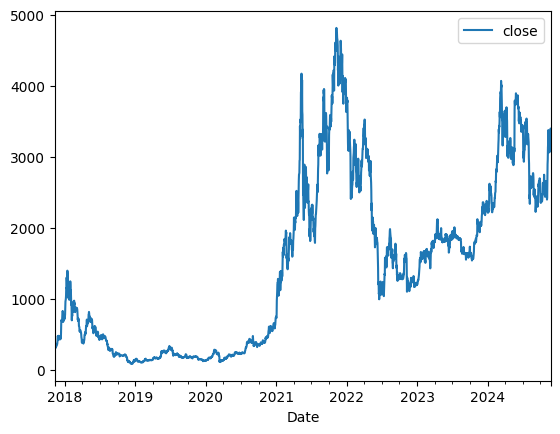

In [37]:
# Creates a line plot of Ethereum's closing prices over time, using the index (dates) as the x-axis.
eth.plot.line(y='close', use_index=True)

In [38]:
# Loads the 'wikipedia_edits.csv' file into a pandas DataFrame, setting the first column as the index and parsing it as datetime.
wiki = pd.read_csv('wikipedia_edits.csv', index_col=0, parse_dates=True)

In [39]:
wiki

,edit_count,sentiment,neg_sentiment
2014-02-25,0.066667,-0.066526,0.066667
2014-02-26,0.033333,-0.033243,0.033333
2014-02-27,0.033333,-0.033243,0.033333
2014-02-28,0.033333,-0.033243,0.033333
2014-03-01,0.033333,-0.033243,0.033333
...,...,...,...
2024-11-20,0.066667,-0.066479,0.066667
2024-11-21,0.033333,-0.033160,0.033333
2024-11-22,0.033333,-0.033160,0.033333
2024-11-23,0.033333,-0.033160,0.033333


In [40]:
eth.index = eth.index.tz_convert(None)  # Convert tz-aware to tz-naive

In [41]:
# Merges the Ethereum price data with the Wikipedia edits data, aligning them on their datetime index.
eth = eth.merge(wiki, left_index=True, right_index=True)

In [42]:
eth

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment
2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984,0.900000,-0.186568,0.275000
2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984,0.966667,-0.219873,0.308333
2017-11-11,298.585999,319.453003,298.191986,314.681000,842300992,0.966667,-0.219873,0.308333
2017-11-12,314.690002,319.153015,298.513000,307.907990,1613479936,0.966667,-0.219873,0.308333
2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984,1.100000,-0.251704,0.341667
...,...,...,...,...,...,...,...,...
2024-11-20,3111.116943,3159.949463,3032.603271,3072.187988,29785491216,0.066667,-0.066479,0.066667
2024-11-21,3072.055176,3388.542969,3035.846680,3361.053955,51619069348,0.033333,-0.033160,0.033333
2024-11-22,3360.654297,3428.460449,3262.808838,3331.600830,36775716442,0.033333,-0.033160,0.033333
2024-11-23,3331.645508,3499.370850,3317.654785,3396.223389,38835184688,0.033333,-0.033160,0.033333


In [43]:
# Creates a new column, 'tomorrow', containing the closing price shifted one day earlier, representing the next day's price
eth['tomorrow'] = eth['close'].shift(-1)

In [44]:
eth

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow
2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984,0.900000,-0.186568,0.275000,299.252991
2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984,0.966667,-0.219873,0.308333,314.681000
2017-11-11,298.585999,319.453003,298.191986,314.681000,842300992,0.966667,-0.219873,0.308333,307.907990
2017-11-12,314.690002,319.153015,298.513000,307.907990,1613479936,0.966667,-0.219873,0.308333,316.716003
2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984,1.100000,-0.251704,0.341667,337.631012
...,...,...,...,...,...,...,...,...,...
2024-11-20,3111.116943,3159.949463,3032.603271,3072.187988,29785491216,0.066667,-0.066479,0.066667,3361.053955
2024-11-21,3072.055176,3388.542969,3035.846680,3361.053955,51619069348,0.033333,-0.033160,0.033333,3331.600830
2024-11-22,3360.654297,3428.460449,3262.808838,3331.600830,36775716442,0.033333,-0.033160,0.033333,3396.223389
2024-11-23,3331.645508,3499.370850,3317.654785,3396.223389,38835184688,0.033333,-0.033160,0.033333,3367.786133


In [45]:
# Creates a 'target' column indicating if the next day's closing price ('tomorrow') is higher than the current day's closing price.  
# Assigns 1 if true (price increases) or 0 otherwise.
eth['target'] = (eth['tomorrow'] > eth['close']).astype(int)  

In [46]:
# Counts and displays the number of occurrences for each unique value (0 or 1) in the 'target' column, showing the distribution of price increases vs. decreases.
eth['target'].value_counts()

target
1    1318
0    1255
Name: count, dtype: int64

In [47]:
from sklearn.ensemble import RandomForestClassifier  
# Imports the RandomForestClassifier from scikit-learn for building a machine learning model.

model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)  
# Initializes a Random Forest classifier with 100 decision trees, a minimum of 50 samples per split, and a fixed random seed for reproducibility.

train = eth.iloc[:-200]  
# Selects all but the last 200 rows of the dataset as the training set.

test = eth[-200:]  
# Selects the last 200 rows of the dataset as the test set.

predictors = ['close', 'volume', 'open', 'high', 'low', 'edit_count', 'sentiment', 'neg_sentiment']  
# Defines the list of predictor features to use for the model.

model.fit(train[predictors], train['target'])  
# Trains the Random Forest model using the predictors to predict the 'target' column in the training set.

RandomForestClassifier(min_samples_split=50, random_state=1)

In [48]:
#baseline precision score
from sklearn.metrics import precision_score  # Imports the precision_score function to evaluate model performance.

preds = model.predict(test[predictors])  
# Generates predictions for the test set using the trained Random Forest model.

preds = pd.Series(preds, index=test.index)  
# Converts the predictions into a pandas Series, aligning them with the test set index for easy comparison.

precision_score(test['target'], preds)  
# Calculates and returns the precision score, measuring the proportion of correctly predicted positive cases out of all predicted positives.

np.float64(0.5321100917431193)

In [49]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['target'])  
    # Trains the given model using the specified predictors and target column from the training set.

    preds = model.predict(test[predictors])  
    # Generates predictions for the test set based on the trained model.

    preds = pd.Series(preds, index=test.index, name='predictions')  
    # Converts the predictions into a pandas Series with the test set index and assigns the name 'predictions'.

    precision_score(test['target'], preds)  
    # Computes the precision score for the predictions against the actual target values in the test set.

    combined = pd.concat([test['target'], preds], axis=1)  
    # Combines the actual target values and predictions into a single DataFrame for comparison.

    return combined  
    # Returns the combined DataFrame containing actual and predicted values.

In [50]:
# Use backtesting to get predictions for as many rows as possible while respecting the order of data
def backtest(data, model, predictors, start=1095, step=150):
    all_predictions = []  # Initializes a list to store predictions from each backtesting iteration.

    for i in range(start, data.shape[0], step):  
        # Iterates through the data, starting from the 'start' index, in steps of 'step' size.

        train = data.iloc[0:i].copy()  
        # Selects all rows from the beginning up to the current index as the training set.

        test = data.iloc[i:(i+step)].copy()  
        # Selects the next 'step' rows as the test set.

        predictions = predict(train, test, predictors, model)  
        # Calls the `predict` function to train the model on the training set and get predictions for the test set

In [51]:
from xgboost import XGBClassifier  # Imports the XGBClassifier from the XGBoost library for gradient boosting classification.

model = XGBClassifier(random_state=1, learning_rate=.1, n_estimators=200)  
# Initializes an XGBoost classifier with a fixed random seed for reproducibility, a learning rate of 0.1, and 200 estimators (trees).

predictions = backtest(eth, model, predictors)  
# Calls the backtest function, using the XGBoost model to make predictions on the 'eth' dataset based on the specified predictors.

In [52]:
# Calculates the precision score by comparing the actual target values ('target') with the predicted values ('predictions') in the backtested predictions DataFrame.
precision_score(predictions['target'], predictions['predictions'])  

np.float64(0.5178236397748592)

In [53]:
def compute_rolling(eth):  
    # Defines a function to calculate rolling averages and create new features for different time horizons.

    horizons = [2,7,60,365]  # Specifies the time horizons (in days) for which rolling statistics will be computed.
    new_predictors = ['close', 'sentiment', 'neg_sentiment']  # Initializes the list of new predictors that will be added during the computation.

    for horizon in horizons:  
        # Loops through each specified horizon to compute rolling statistics.

        rolling_averages = eth.rolling(horizon, min_periods=1).mean()  
        # Computes the rolling mean for each column over the specified horizon, with a minimum of 1 period required for computation.

        ratio_column = f'close_ratio_{horizon}'  
        eth[ratio_column] = eth['close'] / rolling_averages['close']  
        # Creates a new column representing the ratio of the current closing price to the rolling average closing price.

        edit_column = f'edit_{horizon}'  
        eth[edit_column] = rolling_averages['edit_count']  
        # Creates a new column for the rolling average of the 'edit_count' over the specified horizon.

        rolling = eth.rolling(horizon, closed='left', min_periods=1).mean()  
        # Computes the rolling mean for the 'target' column with the 'left' window closure, ensuring the current day's value is not included in the calculation.

        trend_column = f'trend_{horizon}'  
        eth[trend_column] = rolling['target']  
        # Creates a new column representing the rolling average of the 'target' column, which indicates price trend.

        new_predictors += [ratio_column, trend_column, edit_column]  
        # Adds the newly created columns (ratio, trend, and edit count) to the list of predictors.

    return eth, new_predictors

In [55]:
# Calls the 'compute_rolling' function on a copy of the 'eth' DataFrame to calculate rolling averages and create new features.
# The updated 'eth' DataFrame and the list of new predictors are stored in 'eth' and 'new_predictors', respectively.
eth, new_predictors = compute_rolling(eth.copy())

In [57]:
eth

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow,target,...,trend_2,close_ratio_7,edit_7,trend_7,close_ratio_60,edit_60,trend_60,close_ratio_365,edit_365,trend_365
2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984,0.900000,-0.186568,0.275000,299.252991,0,...,NaN,1.000000,0.900000,NaN,1.000000,0.900000,NaN,1.000000,0.900000,NaN
2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984,0.966667,-0.219873,0.308333,314.681000,1,...,0.0,0.965119,0.933333,0.000000,0.965119,0.933333,0.000000,0.965119,0.933333,0.000000
2017-11-11,298.585999,319.453003,298.191986,314.681000,842300992,0.966667,-0.219873,0.308333,307.907990,0,...,0.5,1.009868,0.944444,0.500000,1.009868,0.944444,0.500000,1.009868,0.944444,0.500000
2017-11-12,314.690002,319.153015,298.513000,307.907990,1613479936,0.966667,-0.219873,0.308333,316.716003,1,...,0.5,0.991073,0.950000,0.333333,0.991073,0.950000,0.333333,0.991073,0.950000,0.333333
2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984,1.100000,-0.251704,0.341667,337.631012,1,...,0.5,1.015479,0.980000,0.500000,1.015479,0.980000,0.500000,1.015479,0.980000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-20,3111.116943,3159.949463,3032.603271,3072.187988,29785491216,0.066667,-0.066479,0.066667,3361.053955,1,...,0.0,0.988189,0.066667,0.428571,1.148224,0.063889,0.533333,1.062479,0.177443,0.528767
2024-11-21,3072.055176,3388.542969,3035.846680,3361.053955,51619069348,0.033333,-0.033160,0.033333,3331.600830,0,...,0.5,1.066302,0.061905,0.571429,1.250127,0.063889,0.550000,1.160954,0.177078,0.528767
2024-11-22,3360.654297,3428.460449,3262.808838,3331.600830,36775716442,0.033333,-0.033160,0.033333,3396.223389,1,...,0.5,1.046121,0.057143,0.428571,1.233948,0.063889,0.533333,1.149400,0.176712,0.528767
2024-11-23,3331.645508,3499.370850,3317.654785,3396.223389,38835184688,0.033333,-0.033160,0.033333,3367.786133,0,...,0.5,1.053981,0.052381,0.428571,1.252148,0.063889,0.533333,1.170240,0.176347,0.528767


In [58]:
# Performs backtesting using the 'eth' DataFrame, the trained model, and the list of new predictors (which includes the rolling features).
# The function will generate predictions for each iteration of the backtest and return the combined results.
predictions = backtest(eth, model, new_predictors) 

In [59]:
# Calculates the precision score by comparing the actual target values ('target') with the predicted values ('predictions') from the backtest results.
# The precision score measures the proportion of true positive predictions out of all predicted positives.
precision_score(predictions['target'], predictions['predictions'])  

np.float64(0.5121621621621621)

In [60]:
predictions

,target,predictions
2020-11-08,0,1
2020-11-09,1,1
2020-11-10,1,1
2020-11-11,0,1
2020-11-12,1,1
...,...,...
2024-11-20,1,1
2024-11-21,0,1
2024-11-22,1,1
2024-11-23,0,1
